In [99]:
from functools import partial, reduce
from typing import TypedDict, Optional
from collections import ChainMap

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
import pandas as pd
from IPython.display import HTML

from itertools import chain, combinations

In [100]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [112]:
def balanced_bernouli(P):
    ps = list(powerset(range(P)))
    while True:
        order = np.random.choice(len(ps), len(ps), False)
        for i in order:
            s = np.ones(P)
            s[list(ps[i])] = -1
            yield s

In [66]:
def ak_gain(k, a0=1e-2, A=1000, alpha=0.602):
    """Rule of thumb, A ~ <=10% max iterations expected
    a0 to be smallest of desired changes among theta early on"""
    a = a0 * (1 + A) ** alpha
    return a / (k + 1 + A) ** alpha


def ck_gain(k, c=1e-2, gamma=0.101):
    """Rule of thumb, c ~ std loss noise (e in y = L + e)"""
    return c / (k + 1) ** gamma


def bernouli_sample(p):
    while True:
        proba = np.random.rand(p)
        values = (proba < 0.5).astype(int) * 2 - 1
        yield values

def segmented_uniform_sample(p, width=1.0):
    while True:
        proba = np.random.rand(p)

        values = (proba < 0.5).astype(int) * 2 - 1  # if proba < 0.5, value is 1

        yield (proba + 0.5) * width * values


def approx_gradient(loss, perturb, theta, c):
    # SPSA
    diff = loss(theta + c * perturb) - loss(theta - c * perturb)
    return (diff / (2 * c)) / perturb


def optim_spsa(theta_0, loss_fnc, ak_gen, ck_gen, max_theta_diff=0.1, num_approx=1, perturb_gen=None):
    theta = theta_0
    P = len(theta)
    k = 0
    if perturb_gen is None:
        perturb_gen = bernouli_sample(P)
    while True:
        ak = ak_gen(k)
        ck = ck_gen(k)
        grads = []
        for i, perturb in zip(range(num_approx), perturb_gen):
            grad_i = approx_gradient(loss_fnc, perturb, theta, ck)
            grads.append(grad_i)
        grad = np.mean(grads, axis=0)
        assert grad.shape == theta.shape, grad.shape
        theta_diff = ak * grad
        theta_diff_mag = np.sqrt(theta_diff @ theta_diff)
        if theta_diff_mag > max_theta_diff:
            theta_diff *= max_theta_diff / theta_diff_mag
        theta = theta - theta_diff
        yield theta

def optim_spsa_diff(theta_0, loss_fnc, ak_gen, ck_gen, max_theta_diff=0.1, num_approx=1, perturb_gen=None):
    theta = theta_0
    P = len(theta)
    k = 0
    if perturb_gen is None:
        perturb_gen = bernouli_sample(P)
    while True:
        ak = ak_gen(k)
        ck = ck_gen(k)
        # grad points me in the direction I want to step, I then pick +- 45 off of it to measure
        # normalize unit_grad, 
        unit_grad = -grad / np.linalg.norm(grad)
        left_search = np.array([unit_grad[]])

        grads = []
        for i, perturb in zip(range(num_approx), perturb_gen):
            grad_i = approx_gradient(loss_fnc, perturb, theta, ck)
            grads.append(grad_i)
        grad = np.mean(grads, axis=0)
        assert grad.shape == theta.shape, grad.shape
        theta_diff = ak * grad
        theta_diff_mag = np.sqrt(theta_diff @ theta_diff)
        if theta_diff_mag > max_theta_diff:
            theta_diff *= max_theta_diff / theta_diff_mag
        theta = theta - theta_diff
        yield theta


In [67]:
next(segmented_uniform_sample(2))

array([0.81477591, 0.55880488])

In [68]:
# simple thing is 'root' finding, where loss is just the current value, and theta is x
goal_theta = np.array([1, 1])

def simple_loss(theta):
    diff = np.asarray(theta) - goal_theta
    return np.sqrt(diff@diff)

theta_0 = np.array([0.5, 1.5])

optim = optim_spsa(theta_0, simple_loss, ak_gain, ck_gain)

In [69]:
for i, theta in zip(range(100), optim):
    if i % 10 == 0:
        print(f"{i}: {simple_loss(theta)}")

0: 0.6871067811865474
10: 0.6471067811865473
20: 0.5671067811865469
30: 0.4471067811865464
40: 0.347106781186546
50: 0.20710678118654535
60: 0.1471067811865451
70: 0.04710678118654468
80: 0.0005050633883343617
90: 1.0566133427727766e-06


In [70]:
theta

array([1.00000005, 0.99999995])

In [71]:
thetas = []
optim = optim_spsa(theta_0, simple_loss, partial(ak_gain, a0=1, A=1), partial(ck_gain, c=1e-2))
for i, theta in zip(range(100), optim):
    thetas.append(theta)
    if i % 10 == 0:
        print(f"{i}: {simple_loss(theta)}")

0: 0.7071067811865476
10: 0.007106781186547256
20: 0.007106781186583414
30: 0.09302142825432341
40: 0.09317574291661446
50: 0.09302142825432341
60: 0.09302142825432341
70: 0.09302142825432341
80: 0.09302142825432341
90: 0.09317574291661446


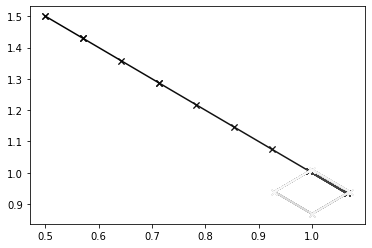

In [72]:
num_segments = len(thetas)
for i in range(len(thetas) - 1):
    x1, y1 = thetas[i]
    x2, y2 = thetas[i+1]
    plt.plot([x1, x2], [y1, y2], color=plt.cm.gray(i / num_segments), marker="x")

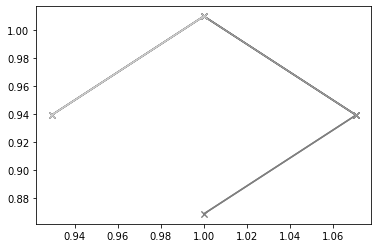

In [73]:
num_segments = 10
for i in range(10 - 1):
    x1, y1 = thetas[-10 + i]
    x2, y2 = thetas[-10 + i+1]
    plt.plot([x1, x2], [y1, y2], color=plt.cm.gray(i / num_segments), marker="x")

In [74]:
# simple thing is 'root' finding, where loss is just the current value, and theta is x
goal_theta = np.array([1, 1])

def noise_source(noise_scale=1e-3):
    return np.random.normal(0, noise_scale, size=len(goal_theta))

def noisy_loss(theta, noise_scale=1e-3, v=None):
    if v is None:
        v = noise_source(noise_scale)
    diff = np.asarray(theta) - goal_theta + v
    return np.sqrt(diff@diff)

theta_0 = np.array([0.5, 1.5])

In [116]:
thetas = []
optim = optim_spsa(theta_0, partial(noisy_loss, noise_scale=1e-1), partial(ak_gain, a0=0.1, A=10), partial(ck_gain, c=1e-2), num_approx=1, perturb_gen=balanced_bernouli(2))
for i, theta in zip(range(50), optim):
    thetas.append(theta)
    if i % 10 == 0:
        print(f"{i}: {simple_loss(theta)}")

0: 0.714142842854285
10: 0.6974103087439258
20: 0.4992598879496733
30: 0.7012039700454668
40: 0.641612711165494


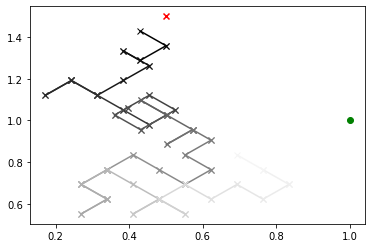

In [117]:
num_segments = len(thetas)
for i in range(len(thetas) - 1):
    x1, y1 = thetas[i]
    x2, y2 = thetas[i+1]
    plt.plot([x1, x2], [y1, y2], color=plt.cm.gray(i / num_segments), marker="x")
plt.scatter(*theta_0, color="r", marker="x")
plt.scatter(*goal_theta, color="g", marker="o")

In [59]:
thetas = []
optim = optim_spsa(theta_0, partial(noisy_loss, noise_scale=1e-1), partial(ak_gain, a0=0.1, A=10), partial(ck_gain, c=0.5))
for i, theta in zip(range(100), optim):
    thetas.append(theta)
    if i % 10 == 0:
        print(f"{i}: {simple_loss(theta)}")

0: 0.7071307976120245
10: 0.2437344664450194
20: 0.02709289910317202
30: 0.03793948086251978
40: 0.02256797663864512
50: 0.035368357304986095
60: 0.03689704327384268
70: 0.03212988101261235
80: 0.03867066724128756
90: 0.026674724401067457


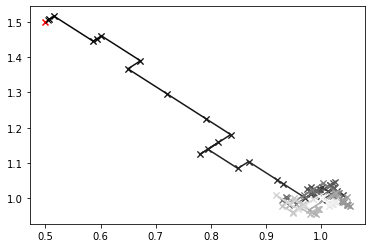

In [60]:
num_segments = len(thetas)
for i in range(len(thetas) - 1):
    x1, y1 = thetas[i]
    x2, y2 = thetas[i+1]
    plt.plot([x1, x2], [y1, y2], color=plt.cm.gray(i / num_segments), marker="x")
plt.scatter(*theta_0, color="r", marker="x")
plt.scatter(*goal_theta, color="g", marker="o")

In [61]:
thetas = []
optim = optim_spsa(theta_0, partial(noisy_loss, noise_scale=1e-1), partial(ak_gain, a0=0.001, A=20), partial(ck_gain, c=0.01))
for i, theta in zip(range(100), optim):
    thetas.append(theta)
    if i % 10 == 0:
        print(f"{i}: {simple_loss(theta)}")

0: 0.6940154075854927
10: 0.6421014674518744
20: 0.6494460534327854
30: 0.6502990423866777
40: 0.6081089869069115
50: 0.5649965812231764
60: 0.5461882179108742
70: 0.5329294561252743
80: 0.504702687529884
90: 0.5047623531964714


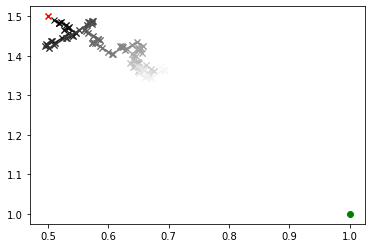

In [62]:
num_segments = len(thetas)
for i in range(len(thetas) - 1):
    x1, y1 = thetas[i]
    x2, y2 = thetas[i+1]
    plt.plot([x1, x2], [y1, y2], color=plt.cm.gray(i / num_segments), marker="x")
plt.scatter(*theta_0, color="r", marker="x")
plt.scatter(*goal_theta, color="g", marker="o")

0: 0.7212797770402473
10: 0.7912381620110815
20: 0.6581704927634906
30: 0.8388949451755088
40: 0.7572656211412827
50: 1.0175761675719701
60: 1.1708178757428658
70: 1.3756478911477246
80: 1.6374169329569441
90: 1.5326141413993746


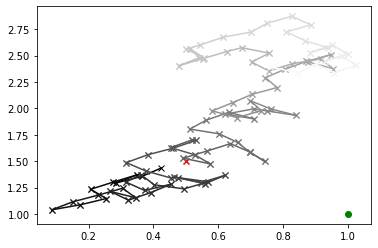

In [63]:
thetas = []
optim = optim_spsa(theta_0, partial(noisy_loss, noise_scale=1e-1), partial(ak_gain, a0=0.1, A=10), partial(ck_gain, c=1e-2), perturb_gen=segmented_uniform_sample(2))
for i, theta in zip(range(100), optim):
    thetas.append(theta)
    if i % 10 == 0:
        print(f"{i}: {simple_loss(theta)}")

num_segments = len(thetas)
for i in range(len(thetas) - 1):
    x1, y1 = thetas[i]
    x2, y2 = thetas[i+1]
    plt.plot([x1, x2], [y1, y2], color=plt.cm.gray(i / num_segments), marker="x")
plt.scatter(*theta_0, color="r", marker="x")
plt.scatter(*goal_theta, color="g", marker="o")

0: 0.697380881670817
10: 0.1099457413745866
20: 0.09421630812276197
30: 0.0715281117131861
40: 0.07761268887612499
50: 0.1461442490273422
60: 0.11931197568154066
70: 0.05113071331006657
80: 0.007639053085344158
90: 0.04610341788407455


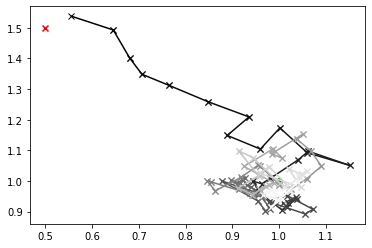

In [64]:
thetas = []
optim = optim_spsa(theta_0, partial(noisy_loss, noise_scale=1e-1), partial(ak_gain, a0=0.05, A=10), partial(ck_gain, c=1e-1), perturb_gen=segmented_uniform_sample(2))
for i, theta in zip(range(100), optim):
    thetas.append(theta)
    if i % 10 == 0:
        print(f"{i}: {simple_loss(theta)}")

num_segments = len(thetas)
for i in range(len(thetas) - 1):
    x1, y1 = thetas[i]
    x2, y2 = thetas[i+1]
    plt.plot([x1, x2], [y1, y2], color=plt.cm.gray(i / num_segments), marker="x")
plt.scatter(*theta_0, color="r", marker="x")
plt.scatter(*goal_theta, color="g", marker="o")

In [132]:
def test():
    return (1, )

a,  = test()
a

1

In [133]:

# def approx_gradient(loss, perturb, theta, c):
#     # SPSA
#     diff = loss(theta + c * perturb) - loss(theta - c * perturb)
#     return (diff / (2 * c)) / perturb

class SPSA_Params(TypedDict):
    a0: float
    c0: float
    A: int
    gamma: float  # 0.101
    alpha: float # 0.602
    max_delta_theta: float  # normalize
    max_iter: int
    t0: float
    num_approx: int


# a = a0 * (1 + A) ** alpha
# return a / (k + 1 + A) ** alpha

class OptimSPSA:
    _default_params: SPSA_Params = {"gamma": 0.101, "alpha": 0.602, "t0": .5, "num_approx": 1} 
    _required_params = {"max_iter", "max_delta_theta"}
    _params: SPSA_Params
    def __init__(self, theta_0, loss_fnc, v_fnc=None, blocking=False, perturb_gen=None, **params):
        self._params = dict(ChainMap(params, self._default_params))
        assert len(self._required_params - set(self._params)) == 0, self._required_params
        self.theta_0 = np.asarray(theta_0)
        self.blocking = blocking
        self.loss = loss_fnc
        self.v_fnc = v_fnc
        self._all_loss_history = []
        self._loss_history = []
        self._used_thetas = []
        self._block_history = []
        self._grad_history = []
        self.thetas = [self.theta_0]
        self.k = 0
        if perturb_gen is None:
            self._perturb_gen = bernouli_sample(len(self.theta_0))
        else:
            self._perturb_gen = perturb_gen(len(self.theta_0))
        self._c_guess = self._params.get("c0")
    
    def reset(self):
        self._all_loss_history = []
        self._loss_history = []
        self._used_thetas = []
        self._block_history = []
        self._grad_history = []
        self.thetas = [self.theta_0]
        self.k = 0
    
    def calibrate(self, debug=False):
        self._params["A"] = self._params["max_iter"] * 0.13
        self._params["c0"] = self._approximate_c(c_guess = self._c_guess)
        # approximate grad, and take magnitude...
        self._params["a0"] = self._approximate_a(self._params["max_delta_theta"])
        if debug:
            print("After calibration: ", self._params)
    
    def _get_loss(self, theta, v=None):
        loss = self.loss(theta, v=v)
        self._all_loss_history.append(loss)
        self._used_thetas.append(theta)
        return loss
    
    def _approximate_a(self, max_delta_theta, num_approx=10):
        approx_grad = np.mean([self.approx_grad() for i in range(num_approx)], axis=0)
        # |a / (k + 1 + A) ** alpha * grad| = max_delta_theta
        max_grad = np.abs(approx_grad).max()
        a0 = (1 + self._params["A"])**self._params["alpha"] * max_delta_theta / max_grad
        return a0

        
    def _approximate_c(self, num_samples=10, c_guess=None):
        losses = [self._get_loss(self.theta_0) for i in range(num_samples)]
        c_est = np.std(losses, ddof=1) * 3  + 1e-10 # over-estimate it...
        if c_guess is None:
            return c_est
        # geometric mean of the guess and estimate
        return np.sqrt(c_est * c_guess)
    
    def _get_perturb(self):
        return next(self._perturb_gen)

    def approx_grad(self):
        c = self.ck(self.k)
        perturb = self._get_perturb()
        left = self.theta + c * perturb
        right = self.theta - c * perturb
        v = None
        if self.v_fnc is not None:
            v = self.v_fnc()
        diff = self._get_loss(left, v=v) - self._get_loss(right, v=v)

        grad = (diff / (2 * c)) / perturb
        self._grad_history.append(grad)
        return grad
    
    def ck(self, k):
        return self._params["c0"] / (k + 1) ** self._params["gamma"]

    def ak(self, k):
        return self._params["a0"] / (k + 1 + self._params["A"]) ** self._params["alpha"]
    
    @property
    def theta(self):
        return self.thetas[-1]

    def step(self):
        a = self.ak(self.k)
        
        for i in range(self._params["num_approx"]):
            self.approx_grad()
        grad = np.mean(self._grad_history[-self._params["num_approx"]:], axis=0)
        theta_diff = a * grad
        theta_diff_mag = np.sqrt(theta_diff @ theta_diff)
        if theta_diff_mag > self._params["max_delta_theta"]:
            theta_diff *= self._params["max_delta_theta"] / theta_diff_mag
        
        # we let it be a max... 
        loss = self.loss(self.theta - theta_diff)  # don't count it...
        block = False
        if self.blocking and self.k > 5:
            std_loss = np.std(self._loss_history[-10:])
            block = loss >= self._loss_history[-1] + std_loss * self.temp(self.k)
        self._block_history.append(block)
        if not block:
            self.thetas.append(self.theta - theta_diff)
            self._loss_history.append(loss)


        self.k += 1
        return self.theta
    
    def temp(self, k):
        return self._params["t0"] / (k + 1)**self._params["gamma"]
    
    def _print_progress(self):
        print(f"{self.k}: {self._loss_history[-1]}")

    def irun(self, num_steps=None, print_progress=True):
        if num_steps is None:
            num_steps = self._params["max_iter"]
        pi = int(num_steps // 10)
        for i in range(num_steps):
            theta = self.step()
            if print_progress and i % pi == 0:
                self._print_progress()
            yield theta
    
    def run(self, num_steps=None, print_progress=True):
        for theta in self.irun(num_steps=num_steps, print_progress=print_progress):
            pass
        return theta

    def rms_dist_from_truth(self, goal_theta):
        diffs = self.thetas - goal_theta
        rms_dist = np.sqrt(np.mean(diffs*diffs,axis=1))
        return rms_dist

    def experiment(self, num_trials, theta_history=False, goal_theta=None):
        losses = []
        dists = []
        thetas = []
        for i in range(num_trials):
            self.reset()
            self.calibrate()
            self.run()
            losses.append(self._loss_history.copy())
            if goal_theta is not None:
                dists.append(self.rms_dist_from_truth(goal_theta))
            if theta_history:
                thetas.append(self.thetas.copy())
        results = [np.array(losses).T]
        if theta_history:
            results.append(np.array(thetas).T)
        if goal_theta is not None:
            results.append(np.array(dists).T)
        return results


optim = OptimSPSA(theta_0, partial(noisy_loss, noise_scale=1e-4), max_delta_theta=0.15, max_iter=100, alpha=1, c0=1e-1)
optim.calibrate()
theta = optim.run()

1: 0.5574056952539619
11: 0.11815058896838576
21: 0.08667838565985776
31: 0.06845658144952473
41: 0.056233313550030646
51: 0.04700879400277208
61: 0.04080272634750621
71: 0.03591992500271235
81: 0.031353489221086696
91: 0.02852207585351438


In [97]:
np.mean(optim.thetas[-10:], axis=0)

array([0.98115341, 1.02258572])

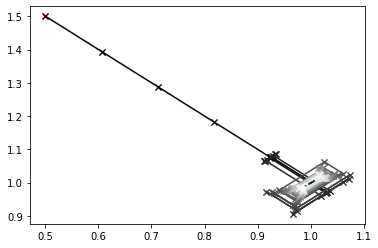

In [105]:
thetas = optim.thetas
num_segments = len(thetas)
for i in range(len(thetas) - 1):
    x1, y1 = thetas[i]
    x2, y2 = thetas[i+1]
    plt.plot([x1, x2], [y1, y2], color=plt.cm.gray(i / num_segments), marker="x")
plt.scatter(*theta_0, color="r", marker="x")
plt.scatter(*goal_theta, color="g", marker="o")

After calibration:  {'gamma': 0.101, 'alpha': 1, 'max_delta_theta': 0.15, 'max_iter': 100, 'c0': 0.005459213479551189, 'A': 13.0, 'a0': 2.487385797445508}
1: 0.7071350675900873
11: 0.10717352028664057
21: 0.07226216160000926
31: 0.055842533411685776
41: 0.04726870153427195
51: 0.039667922122408675
61: 0.03300629324772092
71: 0.02942638389355864
81: 0.02629956806302901
91: 0.023288010128739392


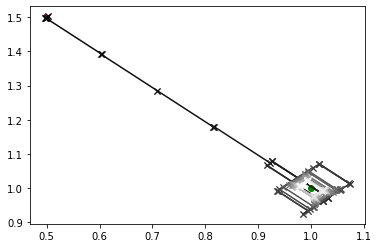

In [108]:
optim = OptimSPSA(theta_0, partial(noisy_loss, noise_scale=1e-4), max_delta_theta=0.15, max_iter=100, alpha=1, c0=1e-1)
optim.calibrate()
optim.run()
thetas = optim.thetas
num_segments = len(thetas)
for i in range(len(thetas) - 1):
    x1, y1 = thetas[i]
    x2, y2 = thetas[i+1]
    plt.plot([x1, x2], [y1, y2], color=plt.cm.gray(i / num_segments), marker="x")
plt.scatter(*theta_0, color="r", marker="x")
plt.scatter(*goal_theta, color="g", marker="o")

After calibration:  {'gamma': 0.101, 'alpha': 1, 't0': 0.5, 'max_delta_theta': 0.15, 'max_iter': 100, 'c0': 0.1567498174237412, 'A': 13.0, 'a0': 2.691205740534525}
1: 0.7485143818900987
11: 0.20272486901707024
21: 0.05511978861711665
31: 0.1101416426510058
41: 0.05604864469429557
51: 0.165412978806444
61: 0.12436403091961977
71: 0.17212263102757255
81: 0.045017139040891066
91: 0.24144887325744835


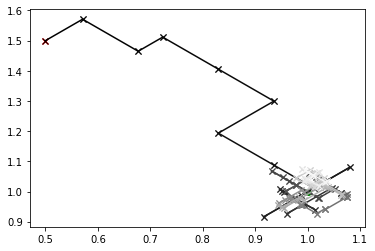

In [129]:
optim = OptimSPSA(theta_0, partial(noisy_loss, noise_scale=1e-1), max_delta_theta=0.15, max_iter=100, alpha=1, c0=1e-1)
optim.calibrate()
optim.run()
thetas = optim.thetas
num_segments = len(thetas)
for i in range(len(thetas) - 1):
    x1, y1 = thetas[i]
    x2, y2 = thetas[i+1]
    plt.plot([x1, x2], [y1, y2], color=plt.cm.gray(i / num_segments), marker="x")
plt.scatter(*theta_0, color="r", marker="x")
plt.scatter(*goal_theta, color="g", marker="o")

After calibration:  {'gamma': 0.101, 'alpha': 1, 't0': 0.5, 'max_delta_theta': 0.15, 'max_iter': 100, 'c0': 0.017764001333002908, 'A': 13.0, 'a0': 2.833026497368123}
1: 0.7095670910119188
11: 0.07205396495711529
21: 0.04085538276144623
31: 0.06427992706659447
41: 0.028285004033968553
51: 0.04967765449355923
61: 0.049271387536524706
71: 0.06017796387248887
81: 0.086207646606661
91: 0.054837715397390574


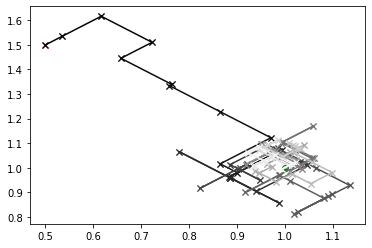

In [130]:
optim = OptimSPSA(theta_0, noisy_loss, v_fnc=partial(noise_source, noise_scale=1e-1), max_delta_theta=0.15, max_iter=100, alpha=1, c0=1e-1)
optim.calibrate()
optim.run()
thetas = optim.thetas
num_segments = len(thetas)
for i in range(len(thetas) - 1):
    x1, y1 = thetas[i]
    x2, y2 = thetas[i+1]
    plt.plot([x1, x2], [y1, y2], color=plt.cm.gray(i / num_segments), marker="x")
plt.scatter(*theta_0, color="r", marker="x")
plt.scatter(*goal_theta, color="g", marker="o")

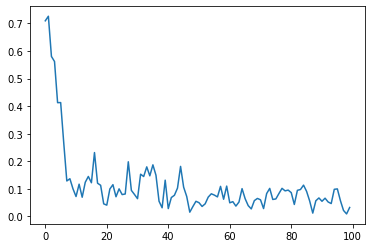

In [131]:
plt.plot(optim._loss_history)

In [176]:
noisy_loss(goal_theta, noise_scale=1e-1)

0.1885236600522169

1: 0.5698037539026813
11: 0.17957850824975394
21: 0.23317183281780396
31: 0.33307507137904935
41: 0.26245774247304876
51: 0.11439261054793787
61: 0.3229767169542889
71: 0.1921406497694167
81: 0.11732891467815514
91: 0.34154687926451477
1: 0.5523889571726217
11: 0.4475988730962259
21: 0.42317385613259667
31: 0.16550628170327503
41: 0.3265240644462109
51: 0.4913225118033193
61: 0.07699242522717037
71: 0.059151763306661935
81: 0.22237601894350303
91: 0.343387125684546
1: 0.888297239311026
11: 0.31921660829975507
21: 0.034912838081052146
31: 0.22865685050927712
41: 0.46686961839685104
51: 0.38811580961503944
61: 0.31066461672039963
71: 0.12501056092642926
81: 0.3344419745222651
91: 0.36861172063405223
1: 0.4798936037692691
11: 0.1610308121092671
21: 0.04684537877026944
31: 0.13646529095442672
41: 0.3254467164105145
51: 0.09689449408950314
61: 0.2845127310459183
71: 0.13664886142839966
81: 0.21345119299866472
91: 0.3516730222882104
1: 0.5695420905748184
11: 0.33304829466831226
21: 0.5340138

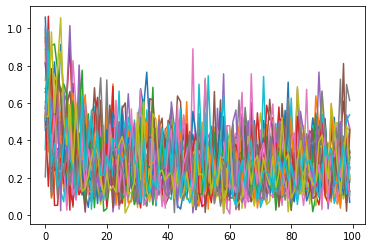

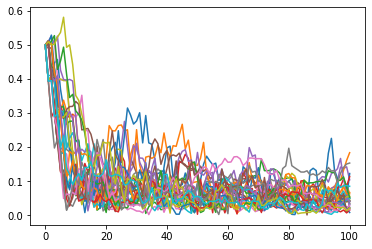

In [138]:
consts = dict(max_delta_theta=0.15, alpha=1.0, max_iter=100, c0=1e-1)
optim = OptimSPSA(theta_0, partial(noisy_loss, noise_scale=0.2), **consts)

losses, dists = optim.experiment(30, goal_theta=goal_theta)

# losses = []
# dists = []
# for i in range(15):
#     optim.reset()
#     optim.calibrate()
#     optim.run()
#     losses.append(optim._loss_history.copy())
#     dists.append(optim.rms_dist_from_truth(goal_theta))

# losses = np.array(losses).T
# dists = np.array(dists).T

plt.plot(losses)
plt.show()
plt.plot(dists)
plt.show()

1: 0.791896747704654
11: 0.27477470285629924
21: 0.26237735910980214
31: 0.5021002452944601
41: 0.06022557322628132
51: 0.4045176041218459
61: 0.06624846324570866
71: 0.2108063177561139
81: 0.2169094180151606
91: 0.2432011086378405
1: 0.8282216476012619
11: 0.371698397683602
21: 0.08654023695097733
31: 0.14311031558910534
41: 0.006275221790068517
51: 0.3596252375976344
61: 0.07356560518229814
71: 0.08304222600451869
81: 0.30975691538620753
91: 0.24864481919656384
1: 0.9689110808741616
11: 0.543195997330912
21: 0.11639104331008537
31: 0.212107999218181
41: 0.08841004809615659
51: 0.19730010852845345
61: 0.4448864763638206
71: 0.1127969850356999
81: 0.3655449345727074
91: 0.18403681367898847
1: 0.364767550906833
11: 0.22116685771530167
21: 0.04095974528051308
31: 0.11855054918893
41: 0.07092317515748657
51: 0.39372762026126534
61: 0.39262961279627373
71: 0.2895048098061888
81: 0.26045608307509543
91: 0.3444780978684119
1: 0.703205014110718
11: 0.3309261965757579
21: 0.5909070018881555
31

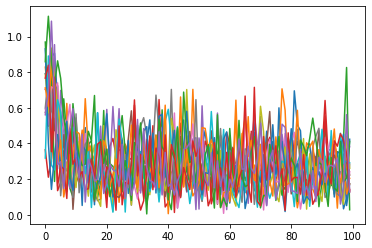

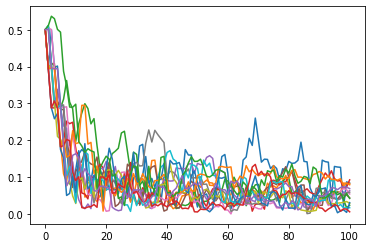

In [128]:
consts = dict(max_delta_theta=0.15, alpha=1.0, max_iter=100, c0=1e-1)
optim = OptimSPSA(theta_0, partial(noisy_loss, noise_scale=0.2), perturb_gen=balanced_bernouli, **consts)


losses = []
dists = []
for i in range(15):
    optim.reset()
    optim.calibrate()
    optim.run()
    losses.append(optim._loss_history.copy())
    dists.append(optim.rms_dist_from_truth(goal_theta))

losses = np.array(losses).T
dists = np.array(dists).T

plt.plot(losses)
plt.show()
plt.plot(dists)
plt.show()

In [166]:
def experiment(optim):
    optim = OptimSPSA(theta_0, partial(noisy_loss, noise_scale=1e-1), max_delta_theta=0.15, max_iter=100, alpha=1.5, c0=1e-1, num_approx=30)
    optim.calibrate()
    optim.run(print_progress=False)    
    return optim._loss_history

losses = np.array(list(zip(*[experiment() for i in range(100)])))
losses.shape

(100, 100)

In [183]:
optim = OptimSPSA(theta_0, partial(noisy_loss, noise_scale=1e-3), max_delta_theta=0.15, max_iter=100, alpha=1.5, c0=1e-1, num_approx=1)
optim.calibrate()
theta = optim.run(print_progress=False)    

In [184]:
theta

array([0.99846489, 1.00074841])

<AxesSubplot:xlabel='Time', ylabel='Value'>

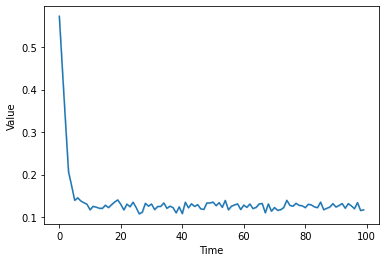

In [167]:

time_points = np.arange(losses.shape[0])
df = pd.DataFrame(losses, columns=[f"Experiment {i+1}" for i in range(losses.shape[1])])
df['Time'] = time_points
df_melted = df.melt(id_vars=['Time'], var_name='Experiment', value_name='Value')
sns.lineplot(data=df_melted, x="Time", y="Value",  ci=0.80)

After calibration:  {'gamma': 0.101, 'alpha': 1, 't0': 0.5, 'max_delta_theta': 0.15, 'max_iter': 100, 'c0': 0.20037526850558537, 'A': 13.0, 'a0': 3.6377578716142067}
1: 0.6272814460418288
11: 0.23254741223008624
21: 0.16432103520417357
31: 0.19349876046648048
41: 0.11389911689205648
51: 0.19843633283719472
61: 0.07898232529334323
71: 0.16850022727883326
81: 0.12476041139831305
91: 0.09510010033657837


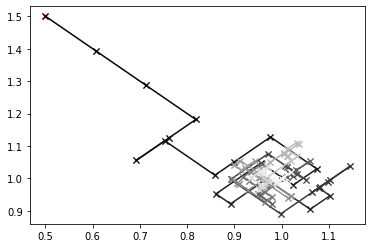

In [132]:
optim = OptimSPSA(theta_0, partial(noisy_loss, noise_scale=1e-1), max_delta_theta=0.15, max_iter=100, alpha=1, c0=1e-1)
optim.calibrate()
optim.run()
thetas = optim.thetas
num_segments = len(thetas)
for i in range(len(thetas) - 1):
    x1, y1 = thetas[i]
    x2, y2 = thetas[i+1]
    plt.plot([x1, x2], [y1, y2], color=plt.cm.gray(i / num_segments), marker="x")
plt.scatter(*theta_0, color="r", marker="x")
plt.scatter(*goal_theta, color="g", marker="o")

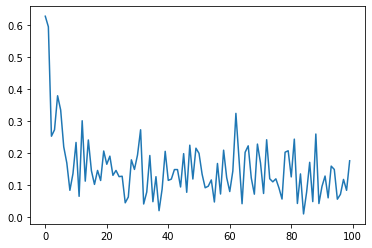

In [133]:
plt.plot(optim._loss_history)

After calibration:  {'gamma': 0.101, 'alpha': 1, 't0': 0.01, 'max_delta_theta': 0.15, 'max_iter': 100, 'c0': 0.16601043379020877, 'A': 13.0, 'a0': 2.8709803545378625}
1: 0.6575557425366739
11: 0.23971402219837634
21: 0.08061346264849711
31: 0.033067257102087834
41: 0.033067257102087834
51: 0.014874364988140725
61: 0.014874364988140725
71: 0.014874364988140725
81: 0.014874364988140725
91: 0.014874364988140725


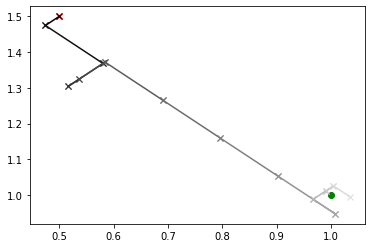

In [125]:
optim = OptimSPSA(theta_0, partial(noisy_loss, noise_scale=1e-1), blocking=True, max_delta_theta=0.15, max_iter=100, alpha=1, c0=1e-1, t0=0.01)
optim.calibrate()
optim.run()
thetas = optim.thetas
num_segments = len(thetas)
for i in range(len(thetas) - 1):
    x1, y1 = thetas[i]
    x2, y2 = thetas[i+1]
    plt.plot([x1, x2], [y1, y2], color=plt.cm.gray(i / num_segments), marker="x")
plt.scatter(*theta_0, color="r", marker="x")
plt.scatter(*goal_theta, color="g", marker="o")

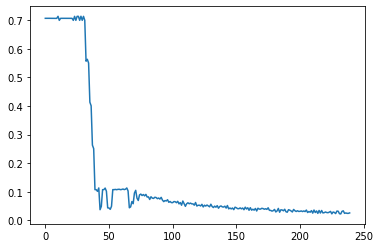

In [103]:
plt.plot(optim._loss_history)

Let's say we have an idea of the max/average distance of t0 to goal, and how noisy we expect it to be

So let's let c be estimated from the measurements, we can do N measurements at the same thing, then approximate...

You might expect that they are relatively interchangeable, but they're not really...

So we expect gradient to decrease as we get closer to 0....


In [72]:
noisy_loss(theta)

0.9991674844653989